Carregar todas bibliotecas necessárias para execução do código:

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from joblib import dump
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score, ConfusionMatrixDisplay
import pandas as pd
import shap
import matplotlib.pyplot as plt

Primeiro passo é extrair o CICIoT 2023, logo depois é processar o arquivo em chunks para criação do dataset com ataques de mirai e tráfego benigno que é nossa área de pesquisa:

In [29]:
import pandas as pd

# Caminho para o arquivo grande
file_path = "/home/michael/Mestrado/METODOS_QT/DatasetFull/CIC_IoT_Dataset_Unificado.csv"

# Caminho para o arquivo de saída
output_path = "/home/michael/Mestrado/METODOS_QT/DatasetFull/CIC_IoT_Dataset_Unificado_resumido.csv"

# Tamanho do chunk
chunk_size = 100000

# Inicializar um arquivo de saída vazio
with open(output_path, 'w') as output_file:
    # Processar o arquivo em chunks
    for i, chunk in enumerate(pd.read_csv(file_path, chunksize=chunk_size)):
        print(f"Processando chunk {i + 1}")
        
        # Filtrar dados que interessam (exemplo: manter apenas "Mirai" e "BenignTraffic")
        filtered_chunk = chunk[
            chunk['label'].str.contains('Mirai', regex=True) | 
            (chunk['label'] == 'BenignTraffic')
        ]
        
        if i == 0:
            # Escrever cabeçalho no primeiro chunk
            filtered_chunk.to_csv(output_file, index=False, mode='w')
        else:
            # Para chunks subsequentes, não incluir cabeçalho
            filtered_chunk.to_csv(output_file, index=False, mode='a', header=False)

print(f"Processo concluído. Dados filtrados salvos em {output_path}")


Processando chunk 1
Processando chunk 2
Processando chunk 3
Processando chunk 4
Processando chunk 5
Processando chunk 6
Processando chunk 7
Processando chunk 8
Processando chunk 9
Processando chunk 10
Processando chunk 11
Processando chunk 12
Processando chunk 13
Processando chunk 14
Processando chunk 15
Processando chunk 16
Processando chunk 17
Processando chunk 18
Processando chunk 19
Processando chunk 20
Processando chunk 21
Processando chunk 22
Processando chunk 23
Processando chunk 24
Processando chunk 25
Processando chunk 26
Processando chunk 27
Processando chunk 28
Processando chunk 29
Processando chunk 30
Processando chunk 31
Processando chunk 32
Processando chunk 33
Processando chunk 34
Processando chunk 35
Processando chunk 36
Processando chunk 37
Processando chunk 38
Processando chunk 39
Processando chunk 40
Processando chunk 41
Processando chunk 42
Processando chunk 43
Processando chunk 44
Processando chunk 45
Processando chunk 46
Processando chunk 47
Processando chunk 48
P

Carregar o novo dataset gerado com o procedimento realizado acima:

In [2]:
# Carregar o novo dataset
novo_dataset = pd.read_csv("/home/michael/Mestrado/METODOS_QT/DatasetFull/CIC_IoT_Dataset_Unificado_resumido.csv")

Identificação das colunas categóricas:

In [3]:
# Identificar colunas categóricas
categorical_columns = novo_dataset.select_dtypes(include=['object']).columns
print(f"Colunas categóricas: {categorical_columns.tolist()}")

Colunas categóricas: ['label']


Aplicar o LabelEncoder:

In [4]:


# Aplicar Label Encoding às colunas categóricas
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    novo_dataset[col] = le.fit_transform(novo_dataset[col])
    label_encoders[col] = le  # Armazenar o encoder para decodificação futura

In [5]:
# Supondo que seu código anterior já foi executado

# Acessar o encoder específico da coluna 'label' que foi armazenado no dicionário
le_label = label_encoders['label']

print("="*40)
print("Mapeamento para a coluna 'label':")
print("="*40)

# O atributo .classes_ armazena as classes originais na ordem em que foram codificadas (0, 1, 2, ...)
for i, classe_original in enumerate(le_label.classes_):
    print(f"O valor original '{classe_original}' foi convertido para o número: {i}")

print("="*40)

Mapeamento para a coluna 'label':
O valor original 'BenignTraffic' foi convertido para o número: 0
O valor original 'Mirai-greeth_flood' foi convertido para o número: 1
O valor original 'Mirai-greip_flood' foi convertido para o número: 2
O valor original 'Mirai-udpplain' foi convertido para o número: 3


Aplicar o ONEHOTENCONDING ***:

In [6]:
# Aplicar One-Hot Encoding
X = pd.get_dummies(novo_dataset, columns=categorical_columns)

Verificando a existência de valores NaN no dataset:

In [6]:
# Verificar colunas que possuem valores NaN (ausentes)
nan_columns = novo_dataset.columns[novo_dataset.isnull().any()]

# Exibir colunas com valores NaN e o número de valores ausentes em cada uma
if len(nan_columns) > 0:
    nan_info = novo_dataset[nan_columns].isnull().sum()
    print("Colunas com valores NaN (ausentes):")
    print(nan_info)
else:
    print("Nenhuma coluna possui valores NaN no dataset.")

Nenhuma coluna possui valores NaN no dataset.


Identificação e remoção de colunas que possuem apenas o valor 0

In [7]:
# Dropar todas as colunas que só contenham o valor 0.0 no dataset
zero_columns = novo_dataset.columns[(novo_dataset == 0.0).all()]

if len(zero_columns) > 0:
    print(f"As seguintes colunas possuem apenas valores 0.0 e serão removidas: {zero_columns.tolist()}")
    novo_dataset = novo_dataset.drop(columns=zero_columns)
else:
    print("Nenhuma coluna contém apenas valores 0.0 no dataset.")
    

As seguintes colunas possuem apenas valores 0.0 e serão removidas: ['Drate', 'ece_flag_number', 'cwr_flag_number', 'Telnet', 'SMTP', 'SSH', 'IRC', 'DHCP']


Mapa de calor com todas as features após a remoção das colunas que continham apenas valores zero:

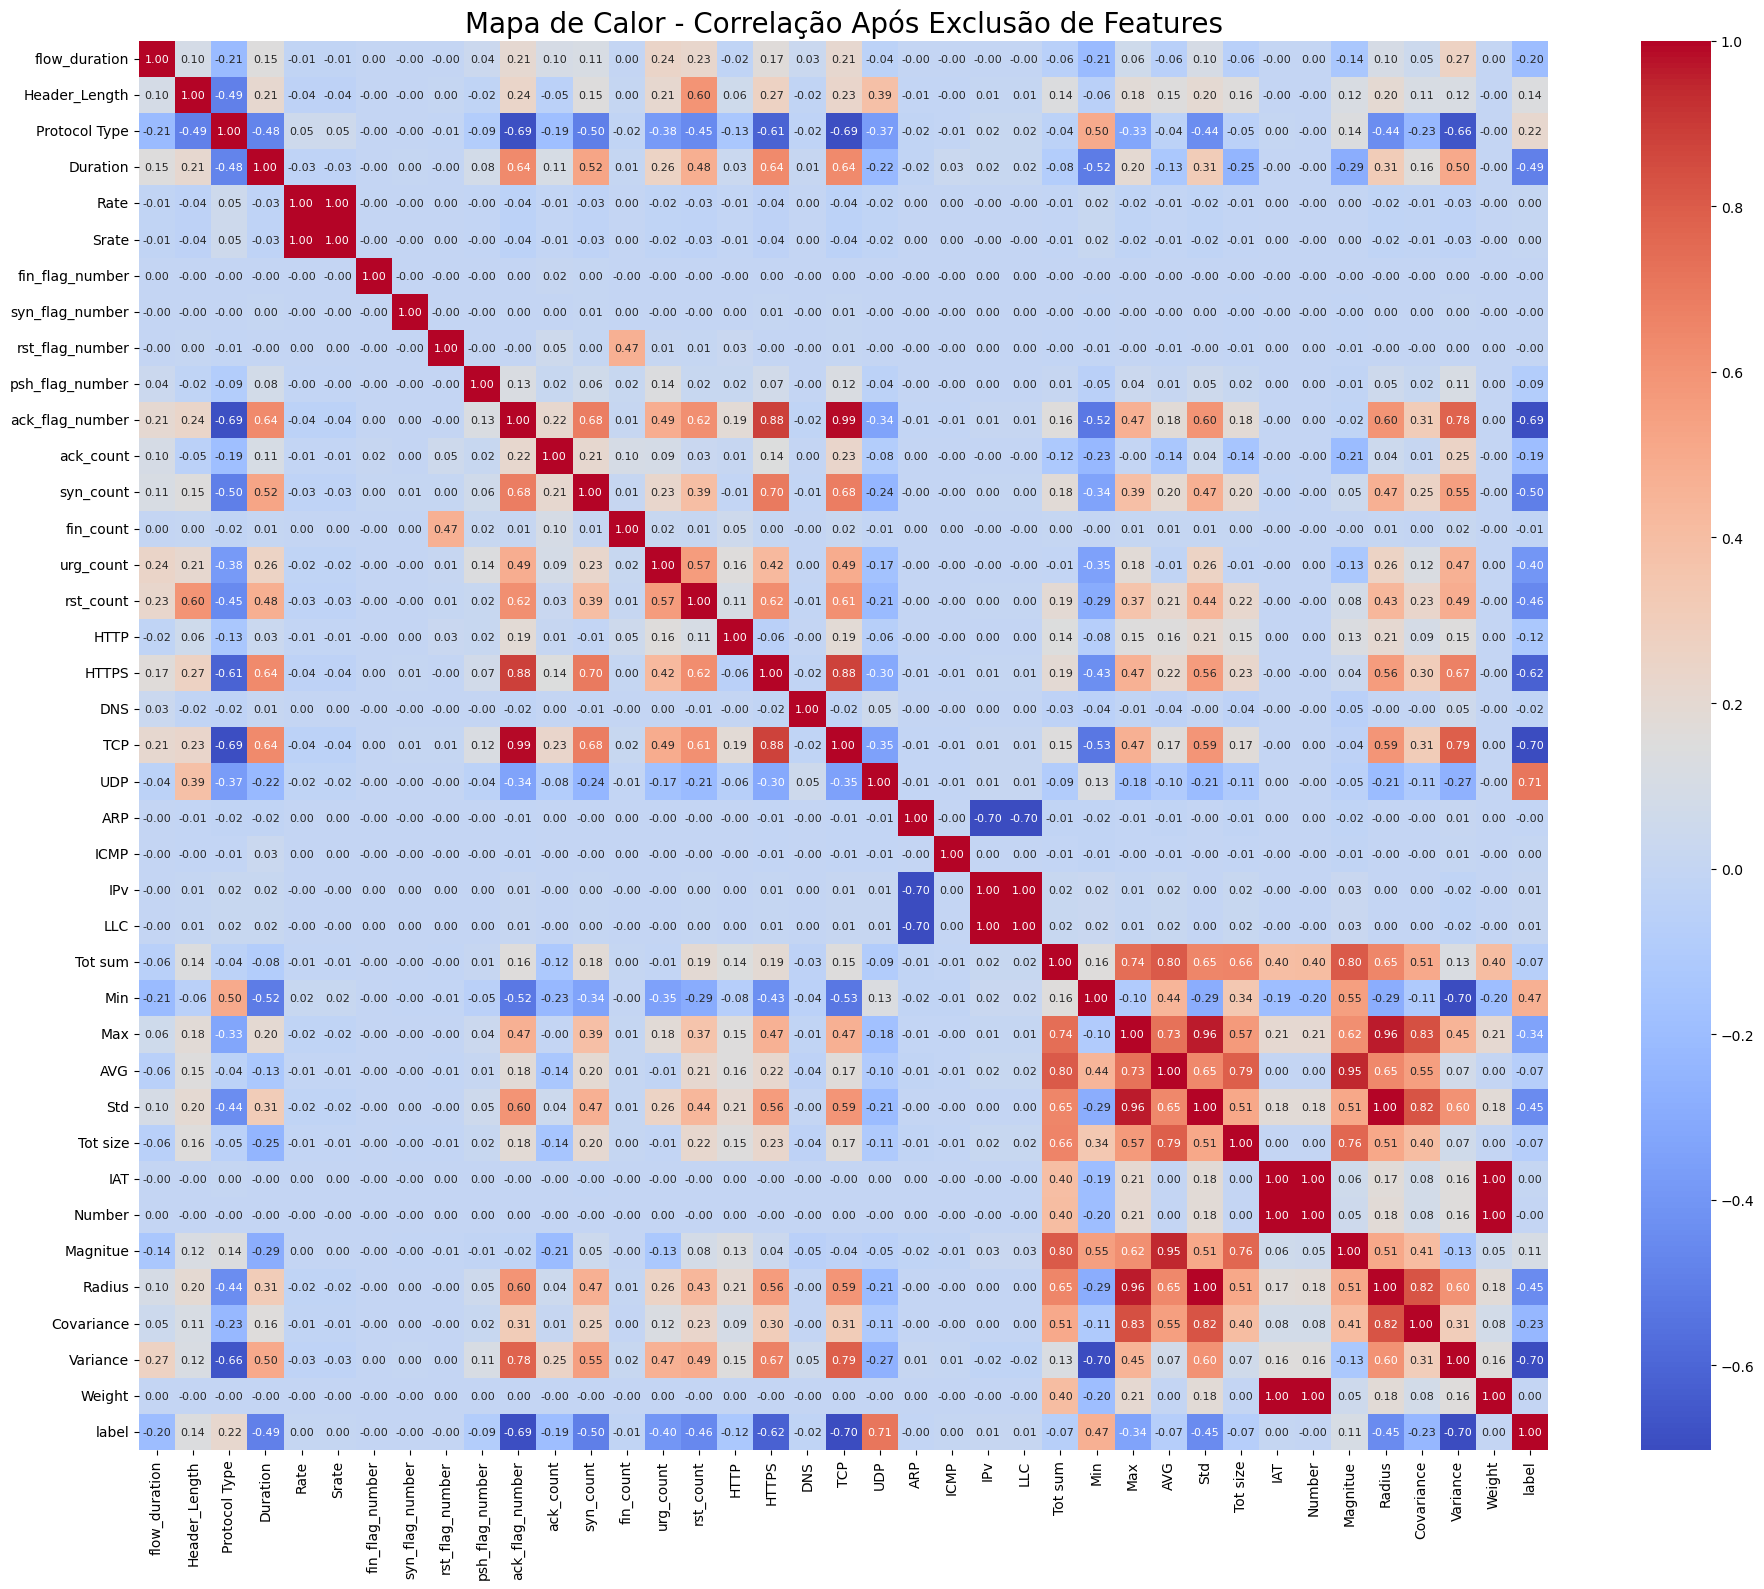

In [8]:



# Gerar o mapa de calor após a exclusão das features que continham apenas valores 0.0

# Recalcular a matriz de correlação
correlation_matrix = novo_dataset.corr()

# Configurar o tamanho da figura maior para melhor visualização
plt.figure(figsize=(20, 16))

# Gerar o mapa de calor
sns.heatmap(
    correlation_matrix,
    annot=True,       # Mostrar os valores no mapa
    fmt=".2f",        # Formatar os valores com duas casas decimais
    cmap="coolwarm",  # Escolher a paleta de cores
    cbar=True,        # Exibir a barra de cores
    square=True,      # Manter células quadradas
    annot_kws={"size": 8}  # Ajustar o tamanho das anotações
)

# Adicionar título e layout
plt.title("Mapa de Calor - Correlação Após Exclusão de Features", fontsize=20)
plt.tight_layout()

# Exibir o gráfico
plt.show()

Análise  baixa correlação e alta correlação e valores parecidos de correlação:

In [9]:
# Limite para correlação baixa com o label
low_correlation_threshold = 0.1

# Limite para alta correlação entre features
high_correlation_threshold = 0.85

# Identificar features com baixa correlação com o label
correlation_with_label = correlation_matrix["label"].drop("label")
low_correlation_features = correlation_with_label[correlation_with_label.abs() < low_correlation_threshold].index

print(f"Features com baixa correlação com o label (menor que {low_correlation_threshold}):")
print(low_correlation_features.tolist())

# Identificar pares de features altamente correlacionadas
high_correlation_pairs = []
for feature in correlation_matrix.columns:
    for other_feature in correlation_matrix.columns:
        if feature != other_feature and abs(correlation_matrix[feature][other_feature]) > high_correlation_threshold:
            high_correlation_pairs.append((feature, other_feature))

print("\nPares de features altamente correlacionadas (maior que 0.85):")
print(high_correlation_pairs)

# Opcional: Remover features redundantes ou com baixa correlação
features_to_remove = set(low_correlation_features)
for pair in high_correlation_pairs:
    # Remover apenas uma das features do par (exemplo: manter a primeira)
    if pair[1] not in features_to_remove:
        features_to_remove.add(pair[1])

print("\nFeatures sugeridas para remoção:")
print(features_to_remove)


Features com baixa correlação com o label (menor que 0.1):
['Rate', 'Srate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'fin_count', 'DNS', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'AVG', 'Tot size', 'IAT', 'Number', 'Weight']

Pares de features altamente correlacionadas (maior que 0.85):
[('Rate', 'Srate'), ('Srate', 'Rate'), ('ack_flag_number', 'HTTPS'), ('ack_flag_number', 'TCP'), ('HTTPS', 'ack_flag_number'), ('HTTPS', 'TCP'), ('TCP', 'ack_flag_number'), ('TCP', 'HTTPS'), ('IPv', 'LLC'), ('LLC', 'IPv'), ('Max', 'Std'), ('Max', 'Radius'), ('AVG', 'Magnitue'), ('Std', 'Max'), ('Std', 'Radius'), ('IAT', 'Number'), ('IAT', 'Weight'), ('Number', 'IAT'), ('Number', 'Weight'), ('Magnitue', 'AVG'), ('Radius', 'Max'), ('Radius', 'Std'), ('Weight', 'IAT'), ('Weight', 'Number')]

Features sugeridas para remoção:
{'ICMP', 'Tot sum', 'rst_flag_number', 'Number', 'ack_flag_number', 'Weight', 'HTTPS', 'Rate', 'syn_flag_number', 'Max', 'fin_flag_number', 'Magnitue',

Remoção das features sugeridas e impressão do novo mapa de calor:

Features restantes no dataset após a remoção:
['flow_duration', 'Header_Length', 'Duration', 'ack_count', 'syn_count', 'urg_count', 'rst_count', 'HTTP', 'UDP', 'Min', 'Covariance', 'Variance', 'label']


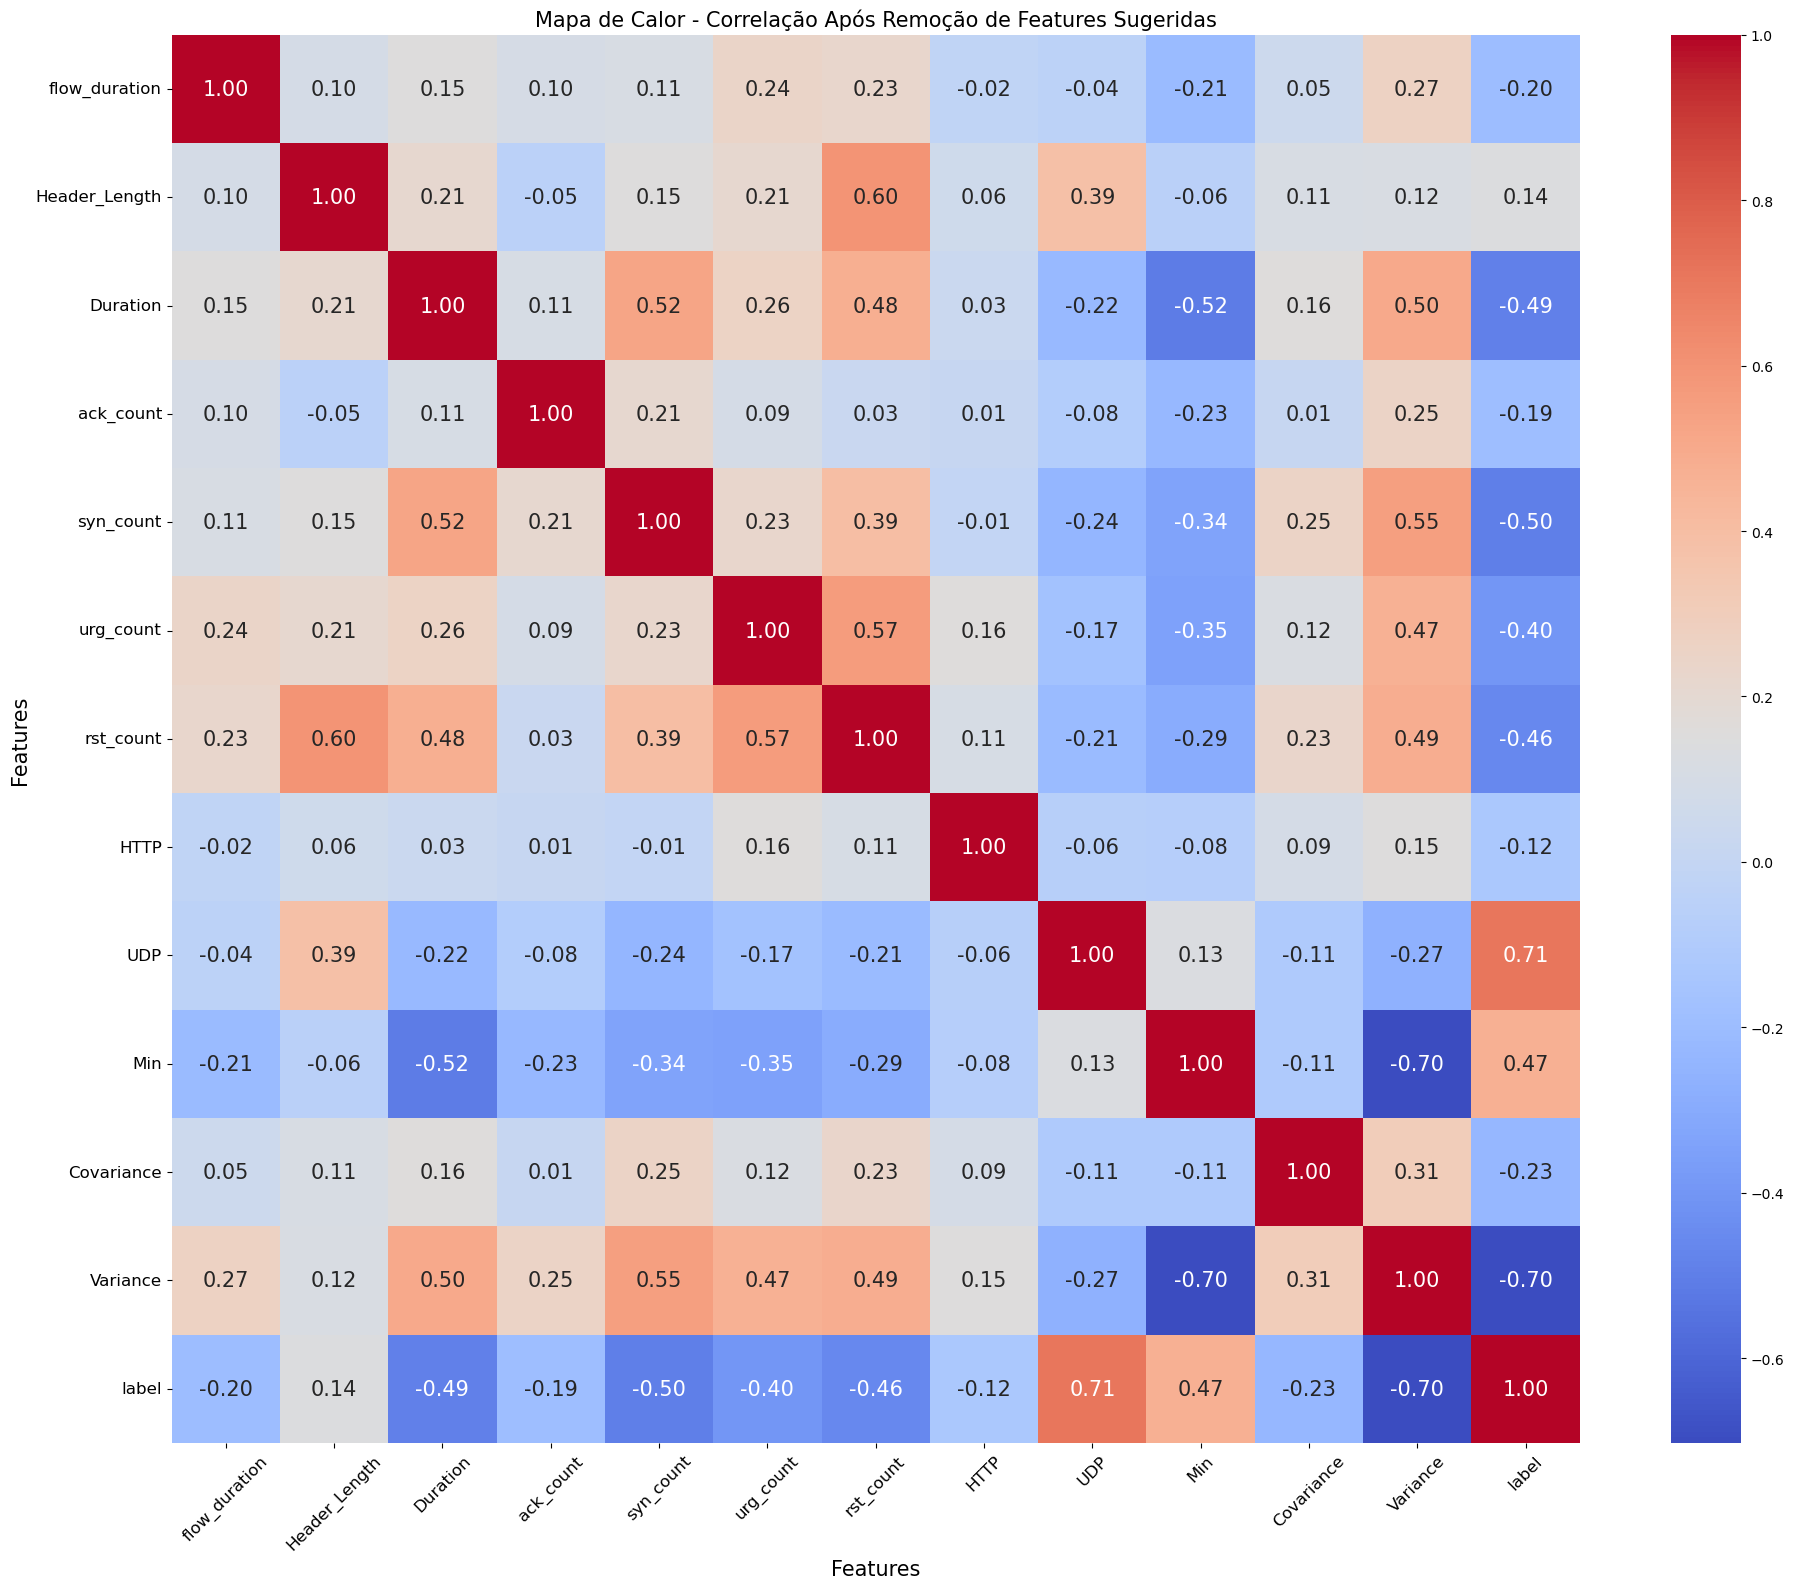

In [10]:
# Remover as features sugeridas do dataset
features_to_remove = {'Radius', 'Srate', 'Max', 'AVG', 'LLC', 'DNS', 'fin_flag_number', 'IPv', 
                      'fin_count', 'Number', 'syn_flag_number', 'ICMP', 'Std', 'Weight', 'IAT', 
                      'Magnitue', 'psh_flag_number', 'ack_flag_number', 'ARP', 'Tot sum', 
                      'Rate', 'TCP', 'HTTPS', 'Tot size', 'rst_flag_number','Protocol Type'}

# Verificar se as features a serem removidas estão no dataset
features_in_dataset = [feature for feature in features_to_remove if feature in novo_dataset.columns]

# Remover as features do dataset
novo_dataset = novo_dataset.drop(columns=features_in_dataset)

# Exibir as features restantes no dataset
print("Features restantes no dataset após a remoção:")
print(novo_dataset.columns.tolist())

# Recalcular o mapa de calor com as features restantes
correlation_matrix_updated = novo_dataset.corr()

# Configurar o tamanho da figura
plt.figure(figsize=(20, 16))

# Gerar o mapa de calor atualizado
sns.heatmap(
    correlation_matrix_updated,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    annot_kws={"size": 15}  # Tamanho das anotações
)

# Ajustar a fonte dos textos externos (título e rótulos dos eixos)
plt.title("Mapa de Calor - Correlação Após Remoção de Features Sugeridas", fontsize=15)
plt.xlabel("Features", fontsize=15)
plt.ylabel("Features", fontsize=15)

# Ajustar o tamanho das fontes dos ticks nos eixos X e Y
plt.xticks(fontsize=12, rotation=45)  # Fonte maior e rotação para legibilidade
plt.yticks(fontsize=12)

# Ajustar espaçamento para evitar cortes
plt.tight_layout()

# Exibir o gráfico
plt.show()





In [12]:
# --- Exportando o DATASET que será utilizado para geração dos modelos .pkl do RF e LGBM que serão utilizados no IDS ---
print("Salvando o dataset com as features restantes em 'dataset_final.csv'...")
novo_dataset.to_csv('dataset_final.csv', index=False)
print("Arquivo salvo com sucesso!")
# --------------------------------

Salvando o dataset com as features restantes em 'dataset_final.csv'...
Arquivo salvo com sucesso!


NOVO ADICIONA O CALCULO DE TEMPO DE TREINAMENTO E INFERENCIA DO RF:

In [13]:
# --- Script Completo para Treino e Avaliação do Random Forest ---

import time
import numpy as np
import pandas as pd # Adicionado para garantir que o script seja autocontido
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    balanced_accuracy_score,
    cohen_kappa_score,
    matthews_corrcoef
)

# --- CARREGAMENTO E PREPARAÇÃO DOS DADOS ---
# Assumindo que a variável 'novo_dataset' (um DataFrame pandas) já foi carregada
# Exemplo:
# novo_dataset = pd.read_csv('seu_dataset_tratado.csv')

# Separar as features e o label
X_rf = novo_dataset.drop(columns=['label'])
y_rf = novo_dataset['label']

# Dividir os dados em treino, validação e teste (70% treino, 15% validação, 15% teste)
X_train_rf, X_temp_rf, y_train_rf, y_temp_rf = train_test_split(X_rf, y_rf, test_size=0.3, stratify=y_rf, random_state=42)
X_val_rf, X_test_rf, y_val_rf, y_test_rf = train_test_split(X_temp_rf, y_temp_rf, test_size=0.5, stratify=y_temp_rf, random_state=42)

# Normalizar os dados com StandardScaler
scaler_rf = StandardScaler()
X_train_scaled_rf = scaler_rf.fit_transform(X_train_rf)
X_val_scaled_rf = scaler_rf.transform(X_val_rf) # Usado para validação intermediária se necessário
X_test_scaled_rf = scaler_rf.transform(X_test_rf)

# --- TREINAMENTO DO MODELO ---
model_rf = RandomForestClassifier(random_state=42)

print("Iniciando o treinamento do modelo Random Forest...")
start_train_time = time.time()
model_rf.fit(X_train_scaled_rf, y_train_rf)
training_time_rf = time.time() - start_train_time
print(f"Treinamento concluído em {training_time_rf:.4f} segundos.")


# --- INFERÊNCIA NO CONJUNTO DE TESTE ---
print("\nIniciando a inferência no conjunto de teste...")
start_inference_time = time.time()
y_test_pred_rf = model_rf.predict(X_test_scaled_rf)
inference_time_rf = time.time() - start_inference_time
print(f"Inferência concluída em {inference_time_rf:.4f} segundos.")


# --- CÁLCULO DE MÉTRICAS COMPLETAS ---

# Métricas Padrão
test_accuracy_rf = accuracy_score(y_test_rf, y_test_pred_rf)
test_precision_rf = precision_score(y_test_rf, y_test_pred_rf, average='weighted')
test_recall_rf = recall_score(y_test_rf, y_test_pred_rf, average='weighted')
test_f1_rf = f1_score(y_test_rf, y_test_pred_rf, average='weighted')

# Métricas robustas a desbalanceamento
test_balanced_accuracy_rf = balanced_accuracy_score(y_test_rf, y_test_pred_rf)
test_kappa_rf = cohen_kappa_score(y_test_rf, y_test_pred_rf)
test_mcc_rf = matthews_corrcoef(y_test_rf, y_test_pred_rf)


# --- EXIBIÇÃO DOS RESULTADOS ---

print("\n" + "="*40)
print("  Resultados Finais - Random Forest")
print("="*40)

print(f"\n--- Tempos ---")
print(f"Tempo de Treinamento: {training_time_rf:.4f} segundos")
print(f"Tempo de Inferência: {inference_time_rf:.4f} segundos")

print(f"\n--- Métricas de Desempenho (Conjunto de Teste) ---")
print(f"Acurácia: {test_accuracy_rf:.4f}")
print(f"Acurácia Balanceada: {test_balanced_accuracy_rf:.4f}")
print(f"F1-Score (Ponderado): {test_f1_rf:.4f}")
print(f"Kappa de Cohen: {test_kappa_rf:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {test_mcc_rf:.4f}")

print("\n--- Relatório de Classificação por Classe ---")
print(classification_report(y_test_rf, y_test_pred_rf))
print("="*40)

Iniciando o treinamento do modelo Random Forest...
Treinamento concluído em 558.3373 segundos.

Iniciando a inferência no conjunto de teste...
Inferência concluída em 8.0150 segundos.

  Resultados Finais - Random Forest

--- Tempos ---
Tempo de Treinamento: 558.3373 segundos
Tempo de Inferência: 8.0150 segundos

--- Métricas de Desempenho (Conjunto de Teste) ---
Acurácia: 0.9759
Acurácia Balanceada: 0.9741
F1-Score (Ponderado): 0.9759
Kappa de Cohen: 0.9677
Matthews Correlation Coefficient (MCC): 0.9677

--- Relatório de Classificação por Classe ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    129062
           1       0.96      0.95      0.96    116647
           2       0.94      0.95      0.94     88297
           3       1.00      1.00      1.00    104677

    accuracy                           0.98    438683
   macro avg       0.97      0.97      0.97    438683
weighted avg       0.98      0.98      0.98    438683



Treinamento e aplicação do modelo RF:

In [11]:


# Separar as features e o label
X_rf = novo_dataset.drop(columns=['label'])
y_rf = novo_dataset['label']

# Dividir os dados em treino, validação e teste (70% treino, 15% validação, 15% teste)
X_train_rf, X_temp_rf, y_train_rf, y_temp_rf = train_test_split(X_rf, y_rf, test_size=0.3, stratify=y_rf, random_state=42)
X_val_rf, X_test_rf, y_val_rf, y_test_rf = train_test_split(X_temp_rf, y_temp_rf, test_size=0.5, stratify=y_temp_rf, random_state=42)

# Verificar os tamanhos dos conjuntos
print(f"Tamanho do conjunto de treino: {len(X_train_rf)}")
print(f"Tamanho do conjunto de validação: {len(X_val_rf)}")
print(f"Tamanho do conjunto de teste: {len(X_test_rf)}")

# Normalizar os dados com StandardScaler
scaler_rf = StandardScaler()

# Ajustar o scaler nos dados de treino e transformar os dados
X_train_scaled_rf = scaler_rf.fit_transform(X_train_rf)

# Apenas transformar (usar o scaler ajustado nos dados de treino) nos dados de validação e teste
X_val_scaled_rf = scaler_rf.transform(X_val_rf)
X_test_scaled_rf = scaler_rf.transform(X_test_rf)

# Criar e treinar o modelo Random Forest
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_scaled_rf, y_train_rf)

# Fazer previsões no conjunto de validação
y_val_pred_rf = model_rf.predict(X_val_scaled_rf)

# Calcular métricas no conjunto de validação
val_accuracy_rf = accuracy_score(y_val_rf, y_val_pred_rf)
val_precision_rf = precision_score(y_val_rf, y_val_pred_rf, average='weighted')
val_recall_rf = recall_score(y_val_rf, y_val_pred_rf, average='weighted')
val_f1_rf = f1_score(y_val_rf, y_val_pred_rf, average='weighted')
val_mse_rf = mean_squared_error(y_val_rf, y_val_pred_rf)
val_rmse_rf = np.sqrt(val_mse_rf)
val_r2_rf = r2_score(y_val_rf, y_val_pred_rf)

# Exibir métricas de validação
print(f"Validação - Accuracy: {val_accuracy_rf:.4f}")
print(f"Validação - Precision: {val_precision_rf:.4f}")
print(f"Validação - Recall: {val_recall_rf:.4f}")
print(f"Validação - F1-Score: {val_f1_rf:.4f}")
print(f"Validação - MSE: {val_mse_rf:.4f}")
print(f"Validação - RMSE: {val_rmse_rf:.4f}")
print(f"Validação - R2-Score: {val_r2_rf:.4f}")

# Fazer previsões no conjunto de teste
y_test_pred_rf = model_rf.predict(X_test_scaled_rf)

# Calcular métricas no conjunto de teste
test_accuracy_rf = accuracy_score(y_test_rf, y_test_pred_rf)
test_precision_rf = precision_score(y_test_rf, y_test_pred_rf, average='weighted')
test_recall_rf = recall_score(y_test_rf, y_test_pred_rf, average='weighted')
test_f1_rf = f1_score(y_test_rf, y_test_pred_rf, average='weighted')
test_mse_rf = mean_squared_error(y_test_rf, y_test_pred_rf)
test_rmse_rf = np.sqrt(test_mse_rf)
test_r2_rf = r2_score(y_test_rf, y_test_pred_rf)

# Exibir métricas de teste
print("\nConjunto de Teste:")
print(f"Accuracy: {test_accuracy_rf:.4f}")
print(f"Precision: {test_precision_rf:.4f}")
print(f"Recall: {test_recall_rf:.4f}")
print(f"F1-Score: {test_f1_rf:.4f}")
print(f"MSE: {test_mse_rf:.4f}")
print(f"RMSE: {test_rmse_rf:.4f}")
print(f"R2-Score: {test_r2_rf:.4f}")

# Relatório completo no conjunto de teste
print("\nClassification Report - Conjunto de Teste:")
print(classification_report(y_test_rf, y_test_pred_rf))


Tamanho do conjunto de treino: 2047182
Tamanho do conjunto de validação: 438682
Tamanho do conjunto de teste: 438683
Validação - Accuracy: 0.9762
Validação - Precision: 0.9762
Validação - Recall: 0.9762
Validação - F1-Score: 0.9762
Validação - MSE: 0.0263
Validação - RMSE: 0.1622
Validação - R2-Score: 0.9798

Conjunto de Teste:
Accuracy: 0.9759
Precision: 0.9760
Recall: 0.9759
F1-Score: 0.9759
MSE: 0.0270
RMSE: 0.1645
R2-Score: 0.9792

Classification Report - Conjunto de Teste:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    129062
           1       0.96      0.95      0.96    116647
           2       0.94      0.95      0.94     88297
           3       1.00      1.00      1.00    104677

    accuracy                           0.98    438683
   macro avg       0.97      0.97      0.97    438683
weighted avg       0.98      0.98      0.98    438683




Gerando SHAP com amostra...


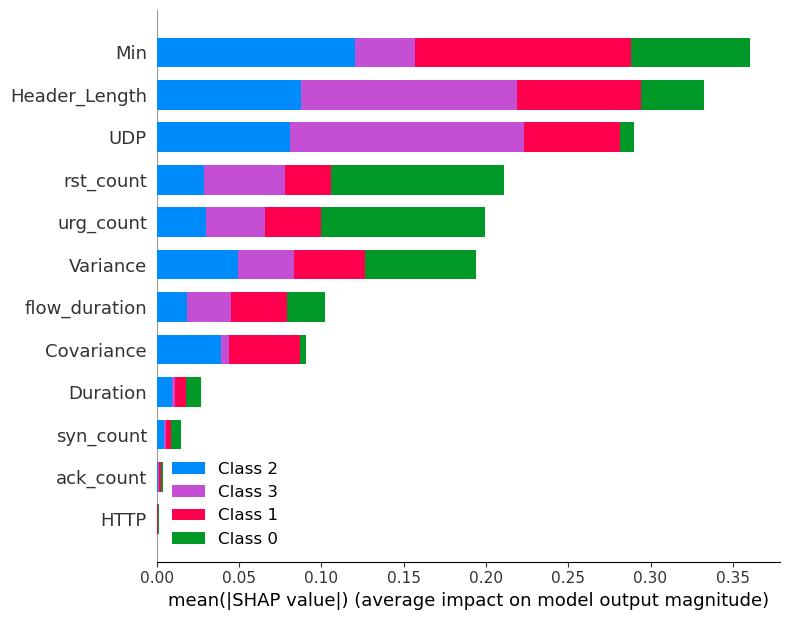

In [12]:
print("\nGerando SHAP com amostra...")

# Converter para DataFrame com colunas
X_test_scaled_rf_df = pd.DataFrame(X_test_scaled_rf, columns=X_rf.columns)

# Amostra de 500 registros para acelerar
X_test_sample = X_test_scaled_rf_df.sample(500, random_state=42)

explainer_rf = shap.TreeExplainer(model_rf)
shap_values_rf = explainer_rf.shap_values(X_test_sample)

# Gráfico de barras (mais rápido)
if isinstance(shap_values_rf, list):
    shap.summary_plot(shap_values_rf[1], X_test_sample, plot_type="bar")
else:
    shap.summary_plot(shap_values_rf, X_test_sample, plot_type="bar")

Plotagem das métricas de avaliação:

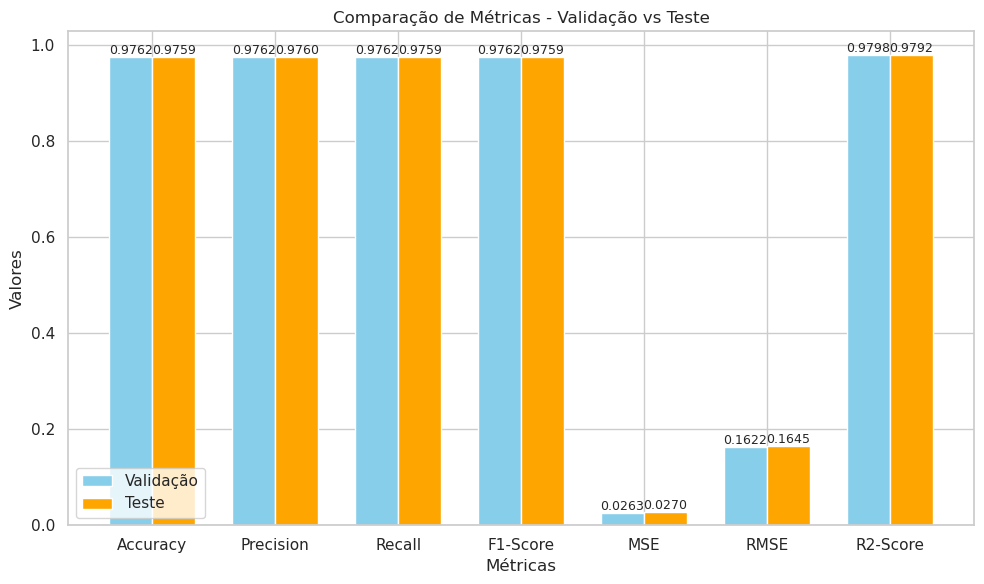

In [41]:


# Dados das métricas para validação e teste
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MSE', 'RMSE', 'R2-Score']
validation_scores = [val_accuracy_rf, val_precision_rf, val_recall_rf, val_f1_rf, val_mse_rf, val_rmse_rf, val_r2_rf]
test_scores = [test_accuracy_rf, test_precision_rf, test_recall_rf, test_f1_rf, test_mse_rf, test_rmse_rf, test_r2_rf]

# Criar o gráfico de barras para comparar as métricas
x = range(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, validation_scores, width, label='Validação', color='skyblue')
ax.bar([p + width for p in x], test_scores, width, label='Teste', color='orange')

# Adicionar rótulos e título
ax.set_xlabel('Métricas')
ax.set_ylabel('Valores')
ax.set_title('Comparação de Métricas - Validação vs Teste')
ax.set_xticks([p + width/2 for p in x])
ax.set_xticklabels(metrics)
ax.legend()

# Adicionar rótulos nos topos das barras
for i in range(len(x)):
    ax.text(i, validation_scores[i], f"{validation_scores[i]:.4f}", ha='center', va='bottom', fontsize=9)
    ax.text(i + width, test_scores[i], f"{test_scores[i]:.4f}", ha='center', va='bottom', fontsize=9)

# Mostrar o gráfico
plt.tight_layout()
plt.show()


Plotagem da matriz de confusão RF:

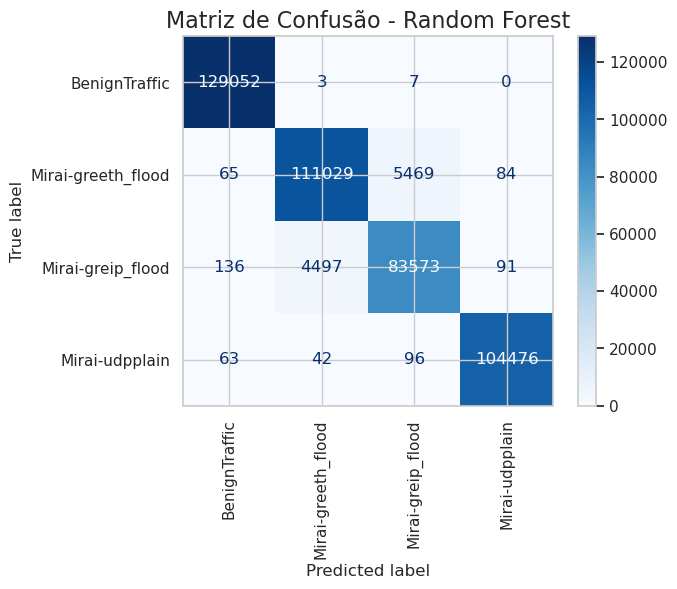

In [42]:

# Recuperar o LabelEncoder do dicionário label_encoders
# Supondo que o nome da coluna original do label é 'label'
le_label = label_encoders['label']

# Gerar a matriz de confusão para o modelo Random Forest
conf_matrix_rf = confusion_matrix(y_test_rf, y_test_pred_rf)

# Recuperar os nomes originais das classes para o Random Forest
class_names_rf = [str(label) for label in le_label.inverse_transform(range(len(le_label.classes_)))]

# Exibir a matriz de confusão para o modelo LightGBM
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=class_names_rf)
disp_rf.plot(cmap="Blues", xticks_rotation='vertical', values_format=".0f")

# Adicionar título
plt.title("Matriz de Confusão - Random Forest", fontsize=16)

# Exibir o gráfico
plt.show()

NOVO COM MEDIÇÃO DE TREINO E DE INFERENCIA:

In [14]:
# --- Script Completo para Treino e Avaliação do LightGBM ---

import time
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    balanced_accuracy_score,
    cohen_kappa_score,        # Importado
    matthews_corrcoef         # Importado
)

# --- CARREGAMENTO E PREPARAÇÃO DOS DADOS ---
# Assumindo que a variável 'novo_dataset' (um DataFrame pandas) já foi carregada
# Exemplo:
# novo_dataset = pd.read_csv('seu_dataset_tratado.csv')

# Preparação dos dados
X_lightgbm = novo_dataset.drop(columns=['label'])
y_lightgbm = novo_dataset['label']

label_encoder_lgbm = LabelEncoder()
y_lightgbm_encoded = label_encoder_lgbm.fit_transform(y_lightgbm)

X_train_lgbm, X_temp_lgbm, y_train_lgbm, y_temp_lgbm = train_test_split(X_lightgbm, y_lightgbm_encoded, test_size=0.3, stratify=y_lightgbm_encoded, random_state=42)
X_val_lgbm, X_test_lgbm, y_val_lgbm, y_test_lgbm = train_test_split(X_temp_lgbm, y_temp_lgbm, test_size=0.5, stratify=y_temp_lgbm, random_state=42)

# Normalizar apenas colunas numéricas (exemplo)
numerical_columns = X_train_lgbm.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X_train_lgbm[numerical_columns] = scaler.fit_transform(X_train_lgbm[numerical_columns])
X_val_lgbm[numerical_columns] = scaler.transform(X_val_lgbm[numerical_columns])
X_test_lgbm[numerical_columns] = scaler.transform(X_test_lgbm[numerical_columns])


train_data_lgbm = lgb.Dataset(X_train_lgbm, label=y_train_lgbm)
val_data_lgbm = lgb.Dataset(X_val_lgbm, label=y_val_lgbm, reference=train_data_lgbm)

params_lgbm = {
    'objective': 'multiclass',
    'num_class': len(label_encoder_lgbm.classes_),
    'learning_rate': 0.1,
    'metric': 'multi_logloss',
    'random_state': 42
}

# --- TREINAMENTO DO MODELO ---
print("Iniciando o treinamento do modelo LightGBM...")
start_train_time = time.time()
model_lgbm = lgb.train(
    params_lgbm,
    train_data_lgbm,
    valid_sets=[val_data_lgbm],
    num_boost_round=100
)
training_time_lgbm = time.time() - start_train_time
print(f"Treinamento concluído em {training_time_lgbm:.4f} segundos.")


# --- INFERÊNCIA NO CONJUNTO DE TESTE ---
print("\nIniciando a inferência no conjunto de teste...")
start_inference_time = time.time()
y_test_pred_proba_lgbm = model_lgbm.predict(X_test_lgbm)
y_test_pred_lgbm = y_test_pred_proba_lgbm.argmax(axis=1)
inference_time_lgbm = time.time() - start_inference_time
print(f"Inferência concluída em {inference_time_lgbm:.4f} segundos.")


# --- CÁLCULO DE MÉTRICAS COMPLETAS ---
test_accuracy_lgbm = accuracy_score(y_test_lgbm, y_test_pred_lgbm)
test_balanced_accuracy_lgbm = balanced_accuracy_score(y_test_lgbm, y_test_pred_lgbm)
test_f1_lgbm = f1_score(y_test_lgbm, y_test_pred_lgbm, average='weighted')
test_kappa_lgbm = cohen_kappa_score(y_test_lgbm, y_test_pred_lgbm)
test_mcc_lgbm = matthews_corrcoef(y_test_lgbm, y_test_pred_lgbm)


# --- EXIBIÇÃO DOS RESULTADOS ---
print("\n" + "="*40)
print("  Resultados Finais - LightGBM")
print("="*40)

print(f"\n--- Tempos ---")
print(f"Tempo de Treinamento: {training_time_lgbm:.4f} segundos")
print(f"Tempo de Inferência: {inference_time_lgbm:.4f} segundos")

print(f"\n--- Métricas de Desempenho (Conjunto de Teste) ---")
print(f"Acurácia: {test_accuracy_lgbm:.4f}")
print(f"Acurácia Balanceada: {test_balanced_accuracy_lgbm:.4f}")
print(f"F1-Score (Ponderado): {test_f1_lgbm:.4f}")
print(f"Kappa de Cohen: {test_kappa_lgbm:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {test_mcc_lgbm:.4f}")

print("\n--- Relatório de Classificação por Classe ---")
class_names_lgbm = [str(label) for label in label_encoder_lgbm.classes_]
print(classification_report(y_test_lgbm, y_test_pred_lgbm, target_names=class_names_lgbm))
print("="*40)

Iniciando o treinamento do modelo LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 2047182, number of used features: 12
[LightGBM] [Info] Start training from score -1.223489
[LightGBM] [Info] Start training from score -1.324620
[LightGBM] [Info] Start training from score -1.603065
[LightGBM] [Info] Start training from score -1.432903
Treinamento concluído em 50.2575 segundos.

Iniciando a inferência no conjunto de teste...
Inferência concluída em 1.0315 segundos.

  Resultados Finais - LightGBM

--- Tempos ---
Tempo de Treinamento: 50.2575 segundos
Tempo de Inferência: 1.0315 segundos

--- Métricas de Desempenho (Conjunto de Teste) ---
Acurácia: 0.9746
Acurácia Balanceada: 0.9727
F1-Score (Ponderado): 0.9746
K

Aplicação do modelo LIGHTGBM:

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.420632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 2047182, number of used features: 12
[LightGBM] [Info] Start training from score -1.223489
[LightGBM] [Info] Start training from score -1.324620
[LightGBM] [Info] Start training from score -1.603065
[LightGBM] [Info] Start training from score -1.432903

Conjunto de Teste - LightGBM:
Accuracy: 0.9746
Precision: 0.9747
Recall: 0.9746
F1-Score: 0.9747
MSE: 0.0272
RMSE: 0.1649
R2-Score: 0.9791

Classification Report - LightGBM:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    129062
           1       0.96      0.95      0.95    116647
           2       0.93      0.94      0.94     88297
           3       1.00      1.00      1.00    104677

    accuracy                           0.97   

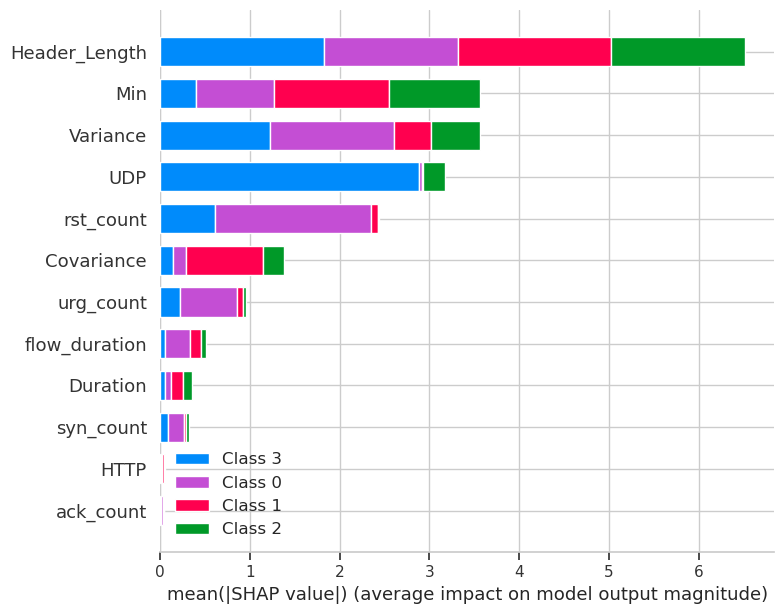

In [ ]:


# Separar colunas categóricas e numéricas
categorical_columns = ['Protocol Type']  # Adicione todas as colunas categóricas aqui
numerical_columns = [col for col in novo_dataset.columns if col not in categorical_columns + ['label']]

# Aplicar Label Encoding às colunas categóricas
#for col in categorical_columns:
#    le = LabelEncoder()
 #   novo_dataset[col] = le.fit_transform(novo_dataset[col])

# Normalizar os dados numéricos
scaler = StandardScaler()
novo_dataset[numerical_columns] = scaler.fit_transform(novo_dataset[numerical_columns])

# Garantir que X e y estão definidos corretamente
X_lightgbm = novo_dataset.drop(columns=['label'])
y_lightgbm = novo_dataset['label']

# Codificar os rótulos (label)
label_encoder_lgbm = LabelEncoder()
y_lightgbm_encoded = label_encoder_lgbm.fit_transform(y_lightgbm)

# Dividir os dados em treino, validação e teste
X_train_lgbm, X_temp_lgbm, y_train_lgbm, y_temp_lgbm = train_test_split(X_lightgbm, y_lightgbm_encoded, test_size=0.3, stratify=y_lightgbm_encoded, random_state=42)
X_val_lgbm, X_test_lgbm, y_val_lgbm, y_test_lgbm = train_test_split(X_temp_lgbm, y_temp_lgbm, test_size=0.5, stratify=y_temp_lgbm, random_state=42)

# Criar datasets do LightGBM
train_data_lgbm = lgb.Dataset(X_train_lgbm, label=y_train_lgbm)
val_data_lgbm = lgb.Dataset(X_val_lgbm, label=y_val_lgbm, reference=train_data_lgbm)

# Parâmetros do modelo LightGBM
params_lgbm = {
    'objective': 'multiclass',
    'num_class': len(label_encoder_lgbm.classes_),
    'learning_rate': 0.1,
    'metric': 'multi_logloss',
    'random_state': 42
}

# Treinar o modelo LightGBM
model_lgbm = lgb.train(
    params_lgbm,
    train_data_lgbm,
    valid_sets=[val_data_lgbm],
    num_boost_round=100
)

# Fazer previsões no conjunto de teste
y_test_pred_proba_lgbm = model_lgbm.predict(X_test_lgbm)
y_test_pred_lgbm = y_test_pred_proba_lgbm.argmax(axis=1)  # Classe com maior probabilidade

# Avaliar o modelo LightGBM
accuracy_lgbm = accuracy_score(y_test_lgbm, y_test_pred_lgbm)
precision_lgbm = precision_score(y_test_lgbm, y_test_pred_lgbm, average='weighted')
recall_lgbm = recall_score(y_test_lgbm, y_test_pred_lgbm, average='weighted')
f1_lgbm = f1_score(y_test_lgbm, y_test_pred_lgbm, average='weighted')

# Cálculo de métricas adicionais
mse_lgbm = mean_squared_error(y_test_lgbm, y_test_pred_lgbm)
rmse_lgbm = mse_lgbm ** 0.5
r2_lgbm = r2_score(y_test_lgbm, y_test_pred_lgbm)

# Exibir métricas
print("\nConjunto de Teste - LightGBM:")
print(f"Accuracy: {accuracy_lgbm:.4f}")
print(f"Precision: {precision_lgbm:.4f}")
print(f"Recall: {recall_lgbm:.4f}")
print(f"F1-Score: {f1_lgbm:.4f}")
print(f"MSE: {mse_lgbm:.4f}")
print(f"RMSE: {rmse_lgbm:.4f}")
print(f"R2-Score: {r2_lgbm:.4f}")

# Relatório de classificação
print("\nClassification Report - LightGBM:")
class_names_lgbm = [str(label) for label in label_encoder_lgbm.classes_]
print(classification_report(y_test_lgbm, y_test_pred_lgbm, target_names=class_names_lgbm))
import shap

# --- EXPLICABILIDADE SHAP PARA LightGBM ---

print("\nGerando SHAP para LightGBM...")

# Criar DataFrame do conjunto de teste (se necessário)
X_test_lgbm_df = pd.DataFrame(X_test_lgbm, columns=X_lightgbm.columns)

# Amostra de até 500 registros para acelerar
X_test_sample_lgbm = X_test_lgbm_df.sample(n=min(500, len(X_test_lgbm_df)), random_state=42)

# Criar o explicador SHAP para modelo LightGBM
explainer_lgbm = shap.TreeExplainer(model_lgbm)

# Calcular valores SHAP
shap_values_lgbm = explainer_lgbm.shap_values(X_test_sample_lgbm)

# Gráfico de barras resumido
if isinstance(shap_values_lgbm, list):
    shap.summary_plot(shap_values_lgbm[1], X_test_sample_lgbm, plot_type="bar")
else:
    shap.summary_plot(shap_values_lgbm, X_test_sample_lgbm, plot_type="bar")




📌 Mapeamento de classes reais:
[0] → BenignTraffic
[1] → Mirai-greeth_flood
[2] → Mirai-greip_flood
[3] → Mirai-udpplain

🔍 Classe alvo: 3 → Mirai-udpplain
✅ Gráfico BARRA CINZA salvo como: shap_global_Mirai-udpplain_cinza.png


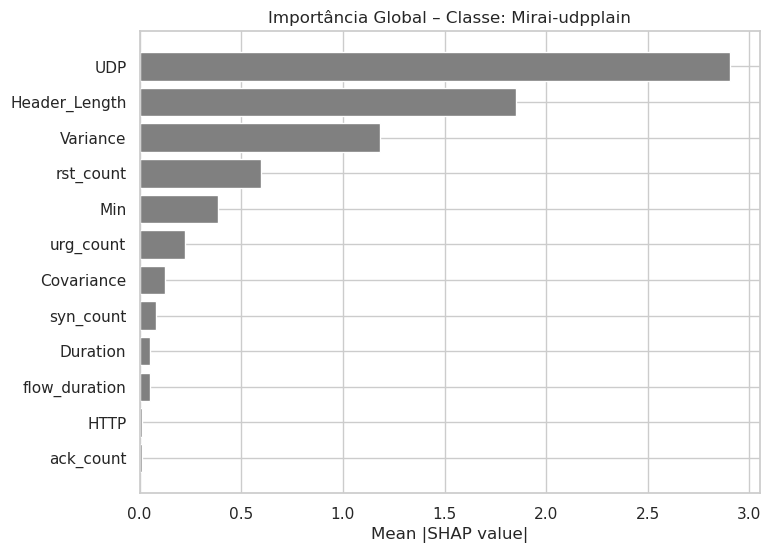

In [29]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ========================
# ✅ 1) Mapeamento manual
# ========================

class_map = {
    0: "BenignTraffic",
    1: "Mirai-greeth_flood",
    2: "Mirai-greip_flood",
    3: "Mirai-udpplain"
}

print("="*40)
print("📌 Mapeamento de classes reais:")
print("="*40)
for k, v in class_map.items():
    print(f"[{k}] → {v}")
print("="*40)

# ==============================
# ✅ 2) Amostra SHAP
# ==============================

amostras = 500
X_sample_lgbm = pd.DataFrame(X_test_lgbm[:amostras], columns=X_lightgbm.columns)

# =========================================
# ✅ 3) Explicador SHAP com API moderna
# =========================================

explainer = shap.Explainer(model_lgbm)
shap_values = explainer(X_sample_lgbm)

# ==================================
# ✅ 4) Definir classe alvo
# ==================================

classe_alvo = 3
classe_nome = class_map[classe_alvo]

print(f"\n🔍 Classe alvo: {classe_alvo} → {classe_nome}")

# ===========================================
# ✅ 5) Pegar médias absolutas SHAP manualmente
# ===========================================

mean_abs_shap = np.abs(shap_values.values[:, :, classe_alvo]).mean(axis=0)
feature_names = X_sample_lgbm.columns

# Ordenar por importância
order = np.argsort(mean_abs_shap)[::-1]
mean_abs_shap_sorted = mean_abs_shap[order]
feature_names_sorted = feature_names[order]

# ==================================
# ✅ 6) Plotar gráfico BARRA CINZA
# ==================================

plt.figure(figsize=(8, 6))
plt.barh(feature_names_sorted, mean_abs_shap_sorted, color='gray')
plt.xlabel("Mean |SHAP value|")
plt.title(f"Importância Global – Classe: {classe_nome}")
plt.gca().invert_yaxis()

# Salvar figura em alta resolução
nome_fig = f"shap_global_{classe_nome}_cinza.png"
plt.savefig(nome_fig, dpi=300, bbox_inches='tight')
print(f"✅ Gráfico BARRA CINZA salvo como: {nome_fig}")

plt.show()


✅ Comparativo salvo: shap_comparativo_cinza.png


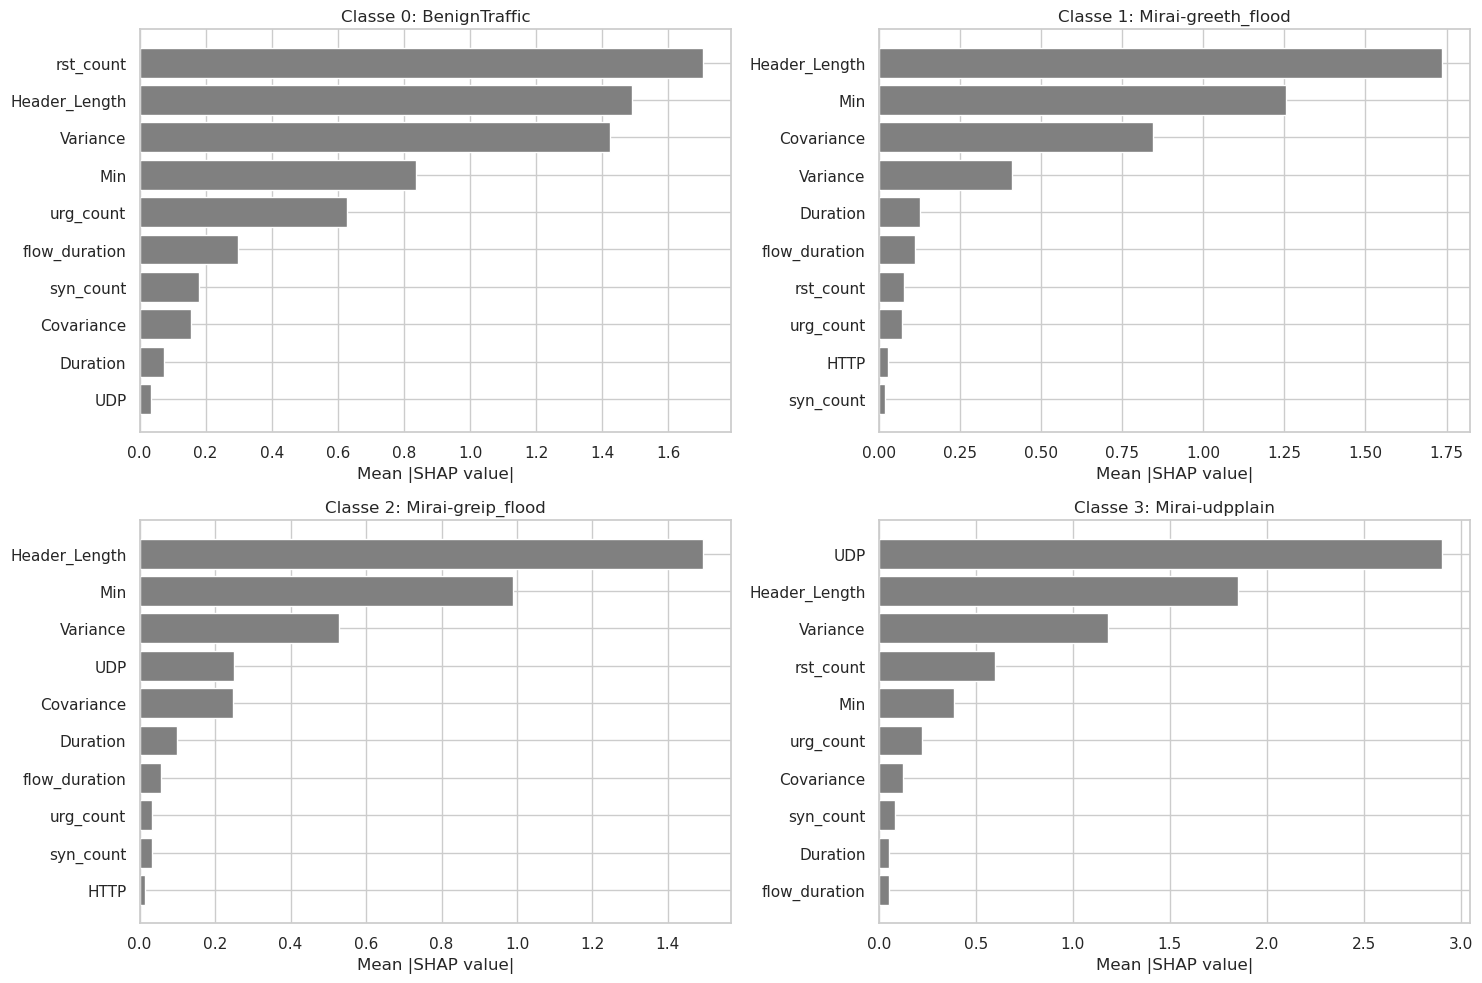

In [32]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Mapeamento manual
class_map = {
    0: "BenignTraffic",
    1: "Mirai-greeth_flood",
    2: "Mirai-greip_flood",
    3: "Mirai-udpplain"
}

# ========================
# ✅ Amostra SHAP
# ========================
amostras = 500
X_sample_lgbm = pd.DataFrame(X_test_lgbm[:amostras], columns=X_lightgbm.columns)

# ✅ Criar explicador e calcular
explainer = shap.Explainer(model_lgbm)
shap_values = explainer(X_sample_lgbm)

# ================================
# ✅ Preparar subplots 2x2
# ================================
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

# ✅ Para cada classe
for classe_alvo in range(4):
    classe_nome = class_map[classe_alvo]

    # Média |SHAP| para classe
    mean_abs_shap = np.abs(shap_values.values[:, :, classe_alvo]).mean(axis=0)
    feature_names = X_sample_lgbm.columns

    # Ordenar top 10
    order = np.argsort(mean_abs_shap)[::-1]
    top_n = 10
    mean_abs_shap_sorted = mean_abs_shap[order][:top_n]
    feature_names_sorted = feature_names[order][:top_n]

    # Plotar barras horizontais
    axs[classe_alvo].barh(feature_names_sorted, mean_abs_shap_sorted, color='gray')
    axs[classe_alvo].invert_yaxis()
    axs[classe_alvo].set_title(f"Classe {classe_alvo}: {classe_nome}")
    axs[classe_alvo].set_xlabel("Mean |SHAP value|")

plt.tight_layout()
plt.savefig("shap_comparativo_cinza.png", dpi=300)
print("✅ Comparativo salvo: shap_comparativo_cinza.png")
plt.show()



=== BenignTraffic ===
rst_count            | Real Mean:    254.383 | Mean |SHAP|: 1.70487
Header_Length        | Real Mean: 586248.505 | Mean |SHAP|: 1.48872
Variance             | Real Mean:      0.343 | Mean |SHAP|: 1.42383
Min                  | Real Mean:    408.227 | Mean |SHAP|: 0.83698
urg_count            | Real Mean:     31.362 | Mean |SHAP|: 0.62874
flow_duration        | Real Mean:     10.454 | Mean |SHAP|: 0.29874
syn_count            | Real Mean:      0.256 | Mean |SHAP|: 0.18073
Covariance           | Real Mean: 179653.765 | Mean |SHAP|: 0.15565
Duration             | Real Mean:     78.856 | Mean |SHAP|: 0.07535
UDP                  | Real Mean:      0.288 | Mean |SHAP|: 0.03474

=== Mirai-greeth_flood ===
Header_Length        | Real Mean: 586248.505 | Mean |SHAP|: 1.73682
Min                  | Real Mean:    408.227 | Mean |SHAP|: 1.25540
Covariance           | Real Mean: 179653.765 | Mean |SHAP|: 0.84389
Variance             | Real Mean:      0.343 | Mean |SHAP|: 0.411

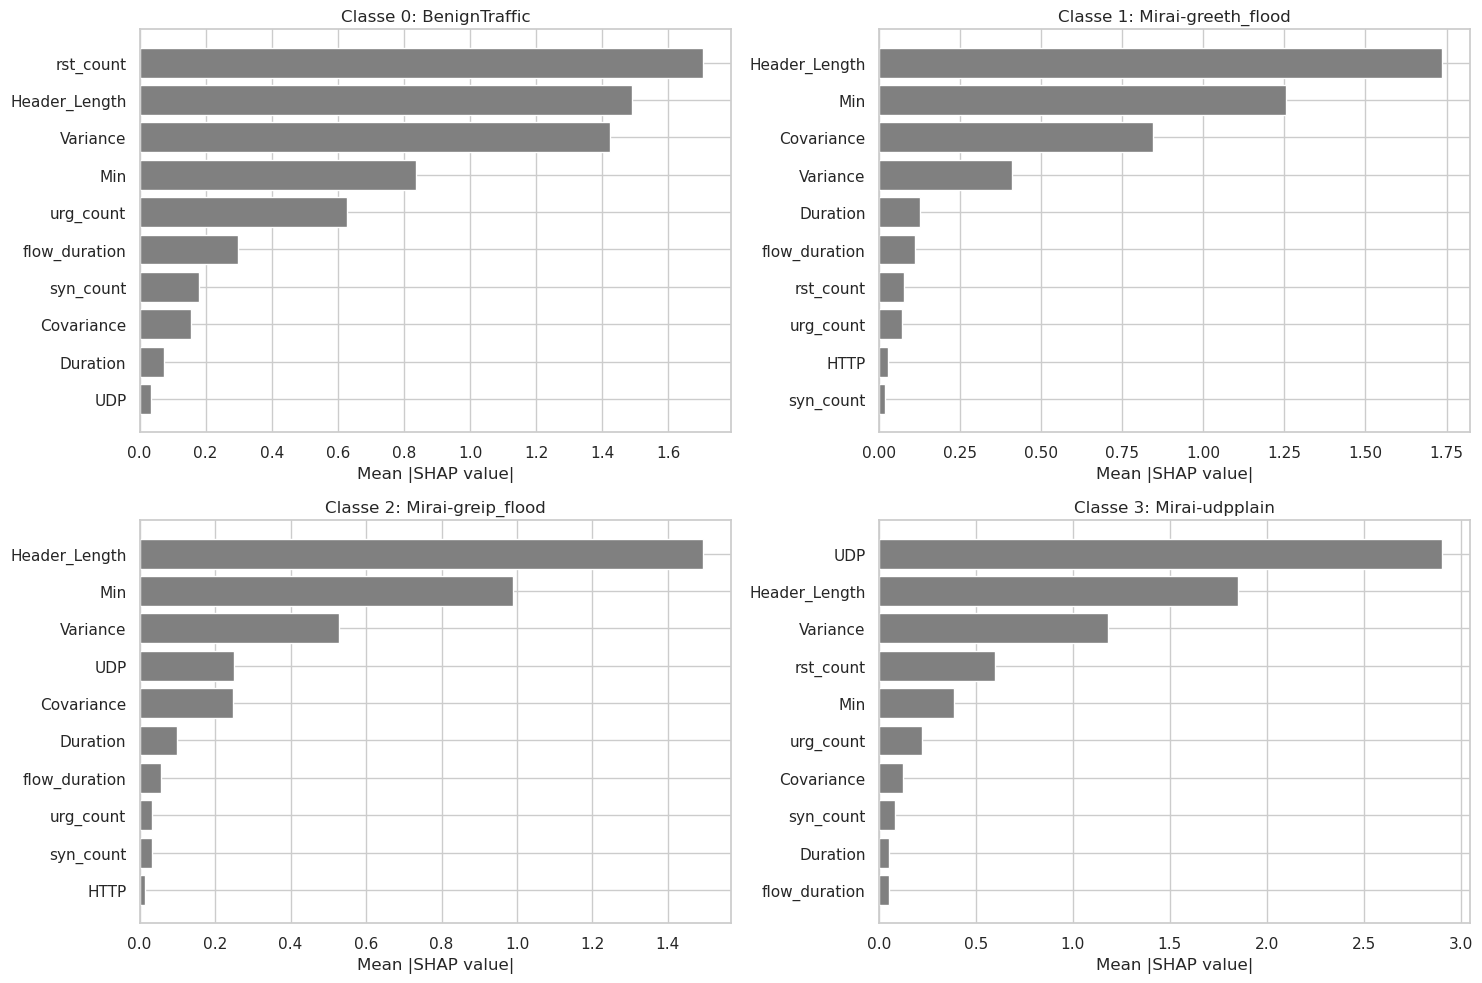

In [16]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Mapeamento manual
class_map = {
    0: "BenignTraffic",
    1: "Mirai-greeth_flood",
    2: "Mirai-greip_flood",
    3: "Mirai-udpplain"
}

# ✅ Amostra SHAP
amostras = 500
X_sample_lgbm = pd.DataFrame(X_test_lgbm[:amostras], columns=X_lightgbm.columns)

# ✅ Criar explicador e calcular
explainer = shap.Explainer(model_lgbm)
shap_values = explainer(X_sample_lgbm)

# ✅ Desnormalizar
# Supondo que seu scaler é o mesmo usado:
# scaler = StandardScaler().fit(X_train)

X_sample_desnorm = X_sample_lgbm.copy()
X_sample_desnorm = X_sample_desnorm * scaler.scale_ + scaler.mean_

# ✅ Preparar subplots 2x2
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

# ✅ Para cada classe
for classe_alvo in range(4):
    classe_nome = class_map[classe_alvo]

    mean_abs_shap = np.abs(shap_values.values[:, :, classe_alvo]).mean(axis=0)
    feature_names = X_sample_lgbm.columns

    order = np.argsort(mean_abs_shap)[::-1]
    top_n = 10
    mean_abs_shap_sorted = mean_abs_shap[order][:top_n]
    feature_names_sorted = feature_names[order][:top_n]

    axs[classe_alvo].barh(feature_names_sorted, mean_abs_shap_sorted, color='gray')
    axs[classe_alvo].invert_yaxis()
    axs[classe_alvo].set_title(f"Classe {classe_alvo}: {classe_nome}")
    axs[classe_alvo].set_xlabel("Mean |SHAP value|")

    # ✅ Mostrar valores reais médios
    print(f"\n=== {classe_nome} ===")
    for f, shap_w in zip(feature_names_sorted, mean_abs_shap_sorted):
        real_mean = X_sample_desnorm[f].mean()
        print(f"{f:20} | Real Mean: {real_mean:10.3f} | Mean |SHAP|: {shap_w:.5f}")

plt.tight_layout()

# ✅ Salvar PNG + PDF
plt.savefig("shap_comparativo_cinza.png", dpi=300)
plt.savefig("shap_comparativo_cinza.pdf")
print("✅ Gráficos salvos em PDF e PNG.")

plt.show()


In [17]:
import pandas as pd
import numpy as np

# ================================
# 1) Parâmetros que já existem
# ================================
# Supondo:
# - X_test_lgbm = dados normalizados do teste
# - scaler = seu StandardScaler já treinado
# - y_test_lgbm = rótulos numéricos das classes (0~3)

class_map = {
    0: "BenignTraffic",
    1: "Mirai-greeth_flood",
    2: "Mirai-greip_flood",
    3: "Mirai-udpplain"
}

# ================================================
# 2) Montar DataFrame com amostra + rótulo junto
# ================================================
amostras = 500
X_sample = pd.DataFrame(X_test_lgbm[:amostras], columns=X_lightgbm.columns)
y_sample = y_test_lgbm[:amostras]

df_sample = X_sample.copy()
df_sample['label'] = y_sample

# ==========================================
# 3) Desnormalizar só colunas numéricas
# ==========================================
X_sample_desnorm = X_sample * scaler.scale_ + scaler.mean_
X_sample_desnorm['label'] = y_sample

# ==========================================
# 4) Calcular médias reais por classe + SHAP
# ==========================================
for classe_num, classe_nome in class_map.items():
    df_classe = X_sample_desnorm[X_sample_desnorm['label'] == classe_num]
    mean_real = df_classe.mean(numeric_only=True)

    # Pega SHAP médio também
    mean_abs_shap = np.abs(shap_values.values[:, :, classe_num]).mean(axis=0)
    feature_names = X_sample.columns

    # Ordenar por SHAP mais relevante
    order = np.argsort(mean_abs_shap)[::-1]
    top_n = 10
    print(f"\n=== {classe_nome} ===")
    for i in range(top_n):
        feat = feature_names[order[i]]
        mean_feat = mean_real[feat]
        mean_shap = mean_abs_shap[order[i]]
        print(f"{feat:<20} | Real Mean: {mean_feat:>12.3f} | Mean |SHAP|: {mean_shap:.5f}")



=== BenignTraffic ===
rst_count            | Real Mean:      870.565 | Mean |SHAP|: 1.70487
Header_Length        | Real Mean:   793470.795 | Mean |SHAP|: 1.48872
Variance             | Real Mean:        0.877 | Mean |SHAP|: 1.42383
Min                  | Real Mean:      149.849 | Mean |SHAP|: 0.83698
urg_count            | Real Mean:      107.308 | Mean |SHAP|: 0.62874
flow_duration        | Real Mean:       33.676 | Mean |SHAP|: 0.29874
syn_count            | Real Mean:        0.824 | Mean |SHAP|: 0.18073
Covariance           | Real Mean:   601506.341 | Mean |SHAP|: 0.15565
Duration             | Real Mean:      110.825 | Mean |SHAP|: 0.07535
UDP                  | Real Mean:        0.089 | Mean |SHAP|: 0.03474

=== Mirai-greeth_flood ===
Header_Length        | Real Mean:       29.078 | Mean |SHAP|: 1.73682
Min                  | Real Mean:      527.904 | Mean |SHAP|: 1.25540
Covariance           | Real Mean:     3961.831 | Mean |SHAP|: 0.84389
Variance             | Real Mean:      


🔍 Classe alvo: 3 – 3

📊 Nomes das features:
['flow_duration', 'Header_Length', 'Duration', 'ack_count', 'syn_count', 'urg_count', 'rst_count', 'HTTP', 'UDP', 'Min', 'Covariance', 'Variance']

📈 Valores SHAP das 5 primeiras amostras para a classe 3:

Amostra 0:
 - flow_duration             =   -0.192 | SHAP = -0.04218
 - Header_Length             =   -0.268 | SHAP = +2.58517
 - Duration                  =   -0.438 | SHAP = -0.00452
 - ack_count                 =   -0.176 | SHAP = -0.00244
 - syn_count                 =   -0.439 | SHAP = +0.03427
 - urg_count                 =   -0.330 | SHAP = +0.19187
 - rst_count                 =   -0.380 | SHAP = +0.82130
 - HTTP                      =   -0.109 | SHAP = +0.00533
 - UDP                       =    1.693 | SHAP = +5.77600
 - Min                       =    0.524 | SHAP = +0.01932
 - Covariance                =   -0.196 | SHAP = +0.07984
 - Variance                  =   -0.846 | SHAP = +2.02369

Amostra 1:
 - flow_duration             =

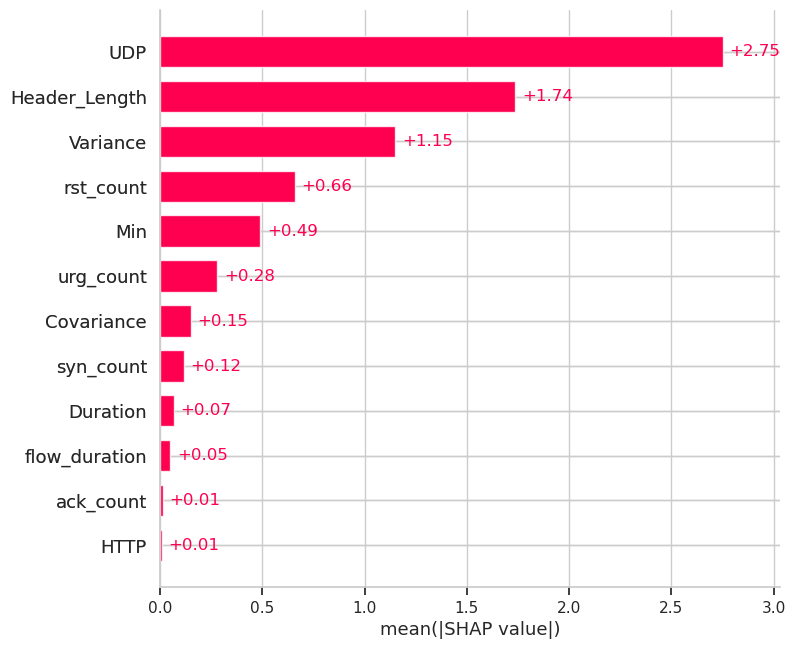


📊 Explicação individual – Force Plot (primeira amostra):


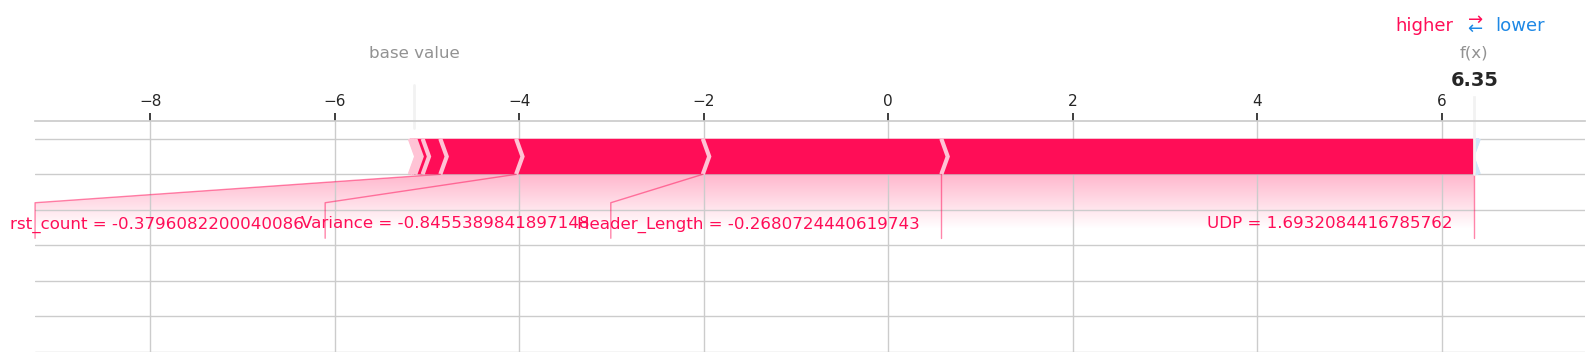

In [16]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# 1) Selecionar amostras com colunas nomeadas
amostras = 100
X_sample_lgbm = pd.DataFrame(X_test_lgbm[:amostras], columns=X_lightgbm.columns)

# 2) Criar explicador usando API moderna (funciona com LightGBM Booster)
explainer = shap.Explainer(model_lgbm)

# 3) Calcular valores SHAP
shap_values = explainer(X_sample_lgbm)

# 4) Mostrar meta-infos
classe_alvo = 3  # Exemplo: classe 0 = Benigno, 1 = GREETH, 2 = GREIP, 3 = UDPPLAIN
classe_nome = label_encoder_lgbm.inverse_transform([classe_alvo])[0]
print(f"\n🔍 Classe alvo: {classe_alvo} – {classe_nome}")

print("\n📊 Nomes das features:")
print(shap_values.feature_names)

print(f"\n📈 Valores SHAP das 5 primeiras amostras para a classe {classe_alvo}:")
for i in range(5):
    print(f"\nAmostra {i}:")
    feature_vals = X_sample_lgbm.iloc[i]
    shap_vals = shap_values[i, :, classe_alvo]
    for feat, val, shap_val in zip(X_sample_lgbm.columns, feature_vals, shap_vals.values):
        print(f" - {feat:<25} = {val:>8.3f} | SHAP = {shap_val:+.5f}")

# 5) Gráfico de importância global (bar plot resumido)
print("\n📊 Gráfico de importância SHAP global para a classe alvo:")
shap.plots.bar(shap_values[:, :, classe_alvo], max_display=20)

# 6) Forçar gráfico individual (force plot)
print("\n📊 Explicação individual – Force Plot (primeira amostra):")
shap.plots.force(shap_values[0, :, classe_alvo], matplotlib=True)

plt.show()


In [17]:
grupo = novo_dataset.copy()
grupo['label_encoded'] = label_encoder_lgbm.transform(grupo['label'])

# Médias por classe
medias = grupo.groupby('label_encoded').mean().round(2)
display(medias[['Header_Length', 'Covariance', 'Variance', 'UDP','Min']])


,Header_Length,Covariance,Variance,UDP,Min
label_encoded,,,,,
0,0.29,0.45,1.38,-0.44,-0.98
1,-0.57,-0.19,-0.59,-0.59,0.48
2,-0.56,-0.19,-0.50,-0.58,0.37
3,0.75,-0.19,-0.62,1.68,0.37


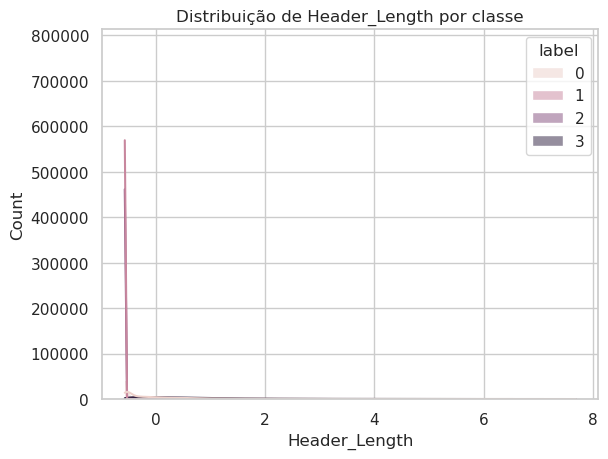

In [27]:
import seaborn as sns

# Exemplo: Header_Length por classe
sns.histplot(data=grupo, x='Header_Length', hue='label', kde=True)
plt.title("Distribuição de Header_Length por classe")
plt.show()


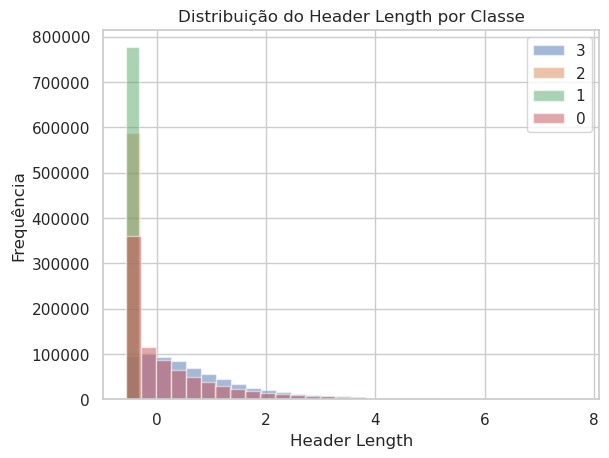

In [38]:
import matplotlib.pyplot as plt

classes = novo_dataset['label'].unique()
for classe in classes:
    subset = novo_dataset[novo_dataset['label'] == classe]
    plt.hist(subset['Header_Length'], bins=30, alpha=0.5, label=classe)

plt.legend()
plt.title("Distribuição do Header Length por Classe")
plt.xlabel("Header Length")
plt.ylabel("Frequência")
plt.show()


Métricas do modelo LGBM:

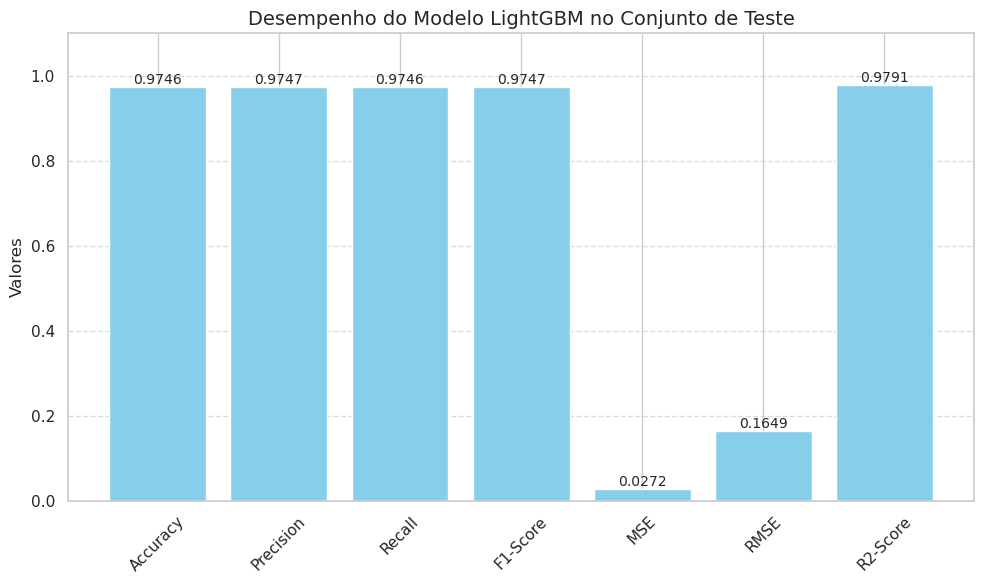

In [18]:


# Dados das métricas do LightGBM no conjunto de teste
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MSE', 'RMSE', 'R2-Score']
values = [accuracy_lgbm, precision_lgbm, recall_lgbm, f1_lgbm, mse_lgbm, rmse_lgbm, r2_lgbm]

# Configuração do gráfico
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color='skyblue')

# Adicionar os valores no topo das barras
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{value:.4f}", ha='center', va='bottom', fontsize=10)

# Personalização do gráfico
plt.title("Desempenho do Modelo LightGBM no Conjunto de Teste", fontsize=14)
plt.ylabel("Valores", fontsize=12)
plt.ylim(0, 1.1)  # Ajustar o limite do eixo Y
plt.xticks(rotation=45, fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Exibir o gráfico
plt.tight_layout()
plt.show()


Matriz de confusão LGBM:

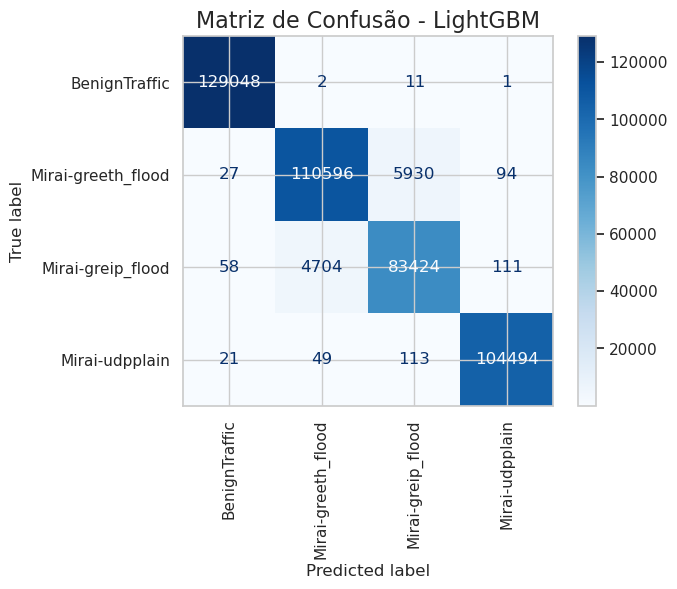

In [45]:


# Gerar a matriz de confusão para o modelo LightGBM
conf_matrix_lgb = confusion_matrix(y_test_lgbm, y_test_pred_lgbm)

# Recuperar o LabelEncoder do dicionário label_encoders
# Supondo que o nome da coluna original do label é 'label'
le_label = label_encoders['label']

# Recuperar os nomes originais das classes para o LightGBM
class_names_lgb = [str(label) for label in le_label.inverse_transform(range(len(le_label.classes_)))]

# Exibir a matriz de confusão para o modelo LightGBM
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_lgb, display_labels=class_names_lgb)
disp.plot(cmap="Blues", xticks_rotation='vertical', values_format=".0f")

# Adicionar título
plt.title("Matriz de Confusão - LightGBM", fontsize=16)

# Exibir o gráfico
plt.show()

Comparação RF X LGBM

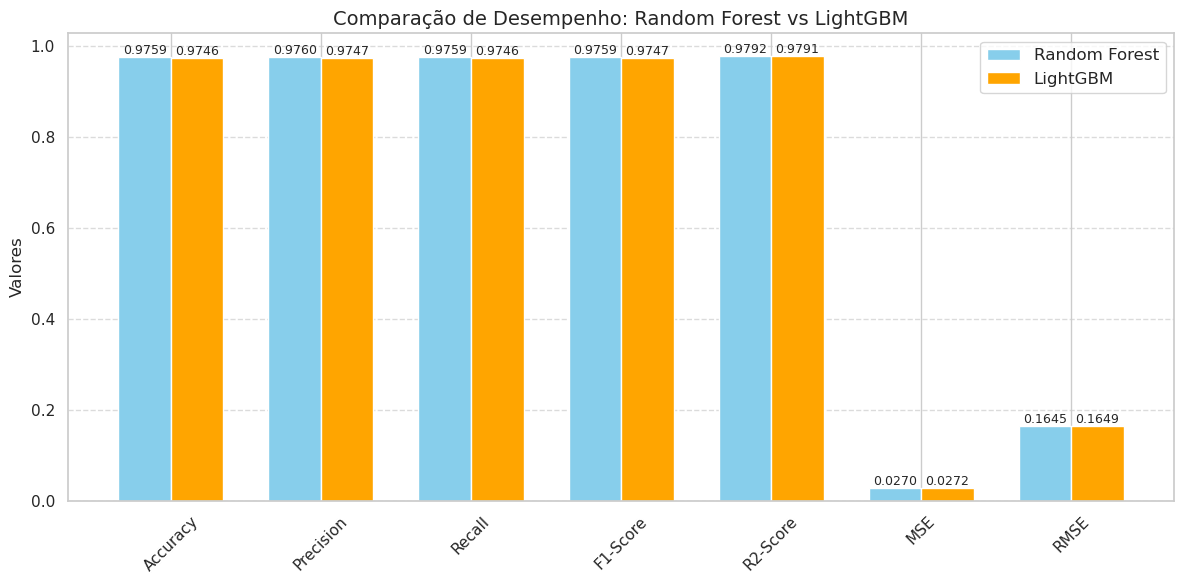

In [46]:


# Dados das métricas para Random Forest e LightGBM
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'R2-Score', 'MSE', 'RMSE', ]
rf_values = [test_accuracy_rf, test_precision_rf, test_recall_rf, test_f1_rf,test_r2_rf, test_mse_rf, test_rmse_rf ]
lgbm_values = [accuracy_lgbm, precision_lgbm, recall_lgbm, f1_lgbm, r2_lgbm, mse_lgbm, rmse_lgbm ]

# Configuração do gráfico
x = np.arange(len(metrics))  # Posições das métricas no eixo X
width = 0.35  # Largura das barras

fig, ax = plt.subplots(figsize=(12, 6))

# Barras para Random Forest e LightGBM
bars_rf = ax.bar(x - width/2, rf_values, width, label='Random Forest', color='skyblue')
bars_lgbm = ax.bar(x + width/2, lgbm_values, width, label='LightGBM', color='orange')

# Adicionar valores no topo das barras
for bars in [bars_rf, bars_lgbm]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Personalização do gráfico
ax.set_title('Comparação de Desempenho: Random Forest vs LightGBM', fontsize=14)
ax.set_ylabel('Valores', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Exibir o gráfico
plt.tight_layout()
plt.show()
